In [2]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

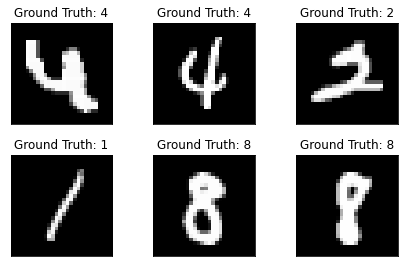

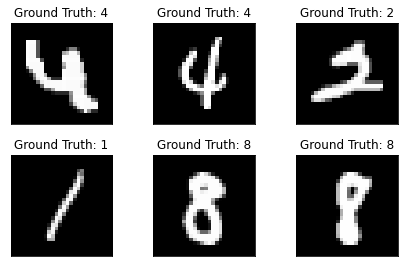

In [7]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

The net

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [43]:
class CosSim2d(nn.Module):
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        kernel=1,
        stride=1,
        units=32,
        depthwise_sep=False,
        padding='valid',
        eps=1e-12
    ):
        super(CosSim2d, self).__init__()
        
        assert kernel in [1, 3, 5], "kernel of this size not supported"
        
        # TODO: kernel stacks, pads, clips
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.units = units
        self.eps = eps
        self.depthwise_sep = depthwise_sep
        
        second_dim  = self.kernel ** 2
        
        if not depthwise_sep: second_dim *= self.in_channels
            
        w_values = torch.empty(1, second_dim, self.units)
        nn.init.xavier_uniform_(w_values)
        self.w = nn.Parameter(w_values, requires_grad=True)
        
        self.p = nn.Parameter(torch.empty(self.units), requires_grad=True)
        nn.init.constant_(self.p, 2)
        
        if padding == 'same':
            self.pad = self.kernel // 2
            self.pad_1 = 1
            self.clip = 0
        elif padding == 'valid':
            self.pad = 0
            self.pad_1 = 0
            self.clip = self.kernel // 2

        if self.kernel == 1:
            self.stack = lambda x: x
        # elif self.kernel == 3:
        #     self.stack = self.stack3x3
        # elif self.kernel == 5:
        #     self.stack = self.stack5x5
        #TODO: Handle all them stacks
        self.stack = lambda x: x
    
    def l2_normal(self, x, axis=None, eps=1e-12):
        square_sum = torch.reduce_sum(torch.square(x), axis, keepdim=True)
        x_inv_norm = torch.sqrt(torch.maximum(square_sum, epsilon))
        return x_inv_norm
    
    def sigplus(self, x):
        return nn.Sigmoid()(x) * nn.Softplus()(x)
    
    def call_body(self, x):
        x = self.stack(x)
        x = x.reshape(-1, self.out_x * self.out_y, self.in_channels * (self.kernel ** 2))
        x_norm = self.l2_normal(x, axis=2, epsilon=self.eps)
        w_norm = self.l2_normal(self.w, axis=1, epsilon=self.eps)
        x = torch.matmul(x / x_norm, self.w / w_norm)
        sign = torch.sign(x)
        x = torch.abs(x) + self.eps
        x = torch.pow(x, self.sigplus(self.p))
        x = sign * x
        x = x.reshape((-1, self.out_y, self.out_x, self.units))
        return x
        
    def forward(self, x):
        self.out_y = math.ceil((x.shape[1] - 2*self.clip) / self.stride)
        self.out_x = math.ceil((x.shape[2] - 2*self.clip) / self.stride)

        # TODO: Calc out_x, out_y,
        if self.depthwise_sep:
            channels = inputs.shape[-1]
            x = tf.vectorized_map(
                self.call_body,
                tf.expand_dims(tf.transpose(inputs, (3,0,1,2)), axis=-1))
            s = x.shape
            x = torch.transpose(x, (1,2,3,4,0))
            x = torch.reshape(
                x, (-1, self.out_y, self.out_x, self.in_channels * self.units))
            return x
        else:
            x = self.call_body(x)
            return x

In [44]:
class CosNet(nn.Module):
    def __init__(self):
        super(CosNet, self).__init__()
        self.cos_sim_1 = CosSim2d(kernel=3, stride=3)
    
    def forward(self, x):
        x = self.cos_sim_1(x)
        return x

In [45]:
CosNet()(example_data)

RuntimeError: shape '[-1, 0, 9]' is invalid for input of size 784000

In [9]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
def train(epoch):
    network.cuda().train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.cuda())
        loss = F.nll_loss(output, target.cuda())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [55]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network.cpu()(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()